In [41]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2 import Error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
try:
    connection = psycopg2.connect(user="lvf7916",
                                  password="xxx",
                                  host="pg.analytics.northwestern.edu",
                                  port="5432",
                                  database="everything2023")

    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()

except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

In [61]:
tx = pd.read_sql("SELECT * FROM group_5.trnsact ORDER BY random() LIMIT 10000000;", connection);
tx

/var/folders/6r/cwd2y27x0yq0d6dg5cj_ndb00000gn/T/ipykernel_79809/3013643095.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tx = pd.read_sql("SELECT * FROM group_5.trnsact ORDER BY random() LIMIT 10000000;", connection);


,SKU,STORE,REGISTER,TRANNUM,SEQ,SALEDATE,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT,INTERID,MIC
0,8738748,1807,150,6100,467400794,2005-07-29,P,1,44.0,44.00,44.00,922400140,860
1,1610504,7307,870,200,1901473,2004-12-23,P,1,5.0,5.00,5.00,707600024,254
2,5838546,4004,570,800,0,2005-03-19,P,1,25.0,18.75,18.75,578700124,519
3,1614064,8609,520,500,689904700,2004-11-08,P,1,39.0,39.00,39.00,387300018,680
4,3718013,2504,320,1500,0,2005-02-19,P,1,18.0,18.00,18.00,222600190,605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,5927301,209,350,500,0,2005-02-23,P,1,40.0,7.00,7.00,835000251,286
9999996,4424599,5103,140,1500,0,2004-11-01,P,1,4.5,4.00,4.00,222800021,254
9999997,5108107,1403,400,15000,0,2004-10-08,R,1,17.5,17.50,17.50,404600069,281
9999998,1536344,7804,140,1400,0,2005-05-21,P,1,24.0,24.00,24.00,853800030,383


In [62]:
if (connection):
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed") 

PostgreSQL connection is closed


In [63]:
tx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   SKU       int64  
 1   STORE     int64  
 2   REGISTER  int64  
 3   TRANNUM   int64  
 4   SEQ       object 
 5   SALEDATE  object 
 6   STYPE     object 
 7   QUANTITY  int64  
 8   ORGPRICE  float64
 9   SPRICE    float64
 10  AMT       float64
 11  INTERID   object 
 12  MIC       int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 991.8+ MB


In [64]:
tx.describe()

,SKU,STORE,REGISTER,TRANNUM,QUANTITY,ORGPRICE,SPRICE,AMT,MIC
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,4.973014e+06,4.440995e+03,4.003628e+02,3.336539e+03,1.000008e+00,3.676318e+01,2.459939e+01,2.459939e+01,4.531541e+02
std,2.836411e+06,2.846992e+03,2.531382e+02,5.320548e+03,2.561445e-02,4.025480e+01,2.708274e+01,2.708274e+01,2.798345e+02
min,3.000000e+00,1.020000e+02,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.630268e+06,2.103000e+03,1.900000e+02,1.000000e+03,1.000000e+00,1.600000e+01,9.880000e+00,9.880000e+00,2.220000e+02
50%,4.857465e+06,4.103000e+03,3.700000e+02,2.200000e+03,1.000000e+00,2.800000e+01,1.800000e+01,1.800000e+01,4.000000e+02
75%,7.391045e+06,7.102000e+03,5.800000e+02,4.100000e+03,1.000000e+00,4.800000e+01,3.100000e+01,3.100000e+01,6.800000e+02
max,9.999997e+06,9.909000e+03,9.930000e+02,9.990000e+04,8.200000e+01,1.200000e+03,9.950000e+02,9.950000e+02,9.990000e+02


## We are interested in exploring the column specifying purchase/return:

In [65]:
def getMedian(x):
    return np.percentile(x, 50)

def countUnique(x):
    return len(x.unique())

In [66]:
tx["PURCHASE"] = np.where(tx["STYPE"]== "P", 1, 0)
tx["RETURN"] = np.where(tx["STYPE"]== "R", 1, 0)

tx_store = pd.pivot_table(tx,
                          values = ['SKU','TRANNUM', 'PURCHASE', "RETURN", "QUANTITY", "ORGPRICE", "AMT"],
                          index = ['STORE'], 
                          aggfunc = {'SKU':'count',
                                     'TRANNUM': countUnique, 
                                     'PURCHASE': 'sum',
                                     'RETURN': 'sum',
                                     'QUANTITY': 'sum',
                                     'ORGPRICE':[np.mean, getMedian, 'std'],
                                     'AMT':[np.mean, getMedian, 'std']})
tx_store

/var/folders/6r/cwd2y27x0yq0d6dg5cj_ndb00000gn/T/ipykernel_79809/617626509.py:4: FutureWarning: The provided callable <function mean at 0x105e0b2e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  tx_store = pd.pivot_table(tx,


AMT                        ORGPRICE                        \
      getMedian       mean        std getMedian       mean        std   
STORE                                                                   
102        20.0  29.665438  33.540740     32.50  43.077213  48.414736   
103        18.5  26.818243  33.012860     30.00  42.853454  53.374618   
107        19.5  26.546710  29.183819     29.00  38.822876  43.262377   
202        17.5  22.779782  22.995025     29.00  36.198069  37.930047   
203        17.5  25.082991  30.420512     29.50  40.040820  48.397183   
...         ...        ...        ...       ...        ...        ...   
9704       16.0  21.142865  21.133121     21.25  30.346648  29.696166   
9709       15.4  20.638140  20.844166     24.00  31.361702  28.601217   
9804       18.0  23.827712  25.171349     25.00  33.683390  37.420629   
9806       21.5  31.043129  33.459793     25.00  35.550958  39.705316   
9909       15.0  20.712997  24.851294     24.00  32.255166  36.165568   

      PURCHASE QUANTITY RETURN    SKU     TRANNUM  
           sum      sum    sum  count countUnique  
STORE                                              
102      42140    45465   3325  45465         336  
103      36941    40528   3587  40528         360  
107      56210    61281   5071  61281         601  
202      23978    26066   2088  26066         266  
203      34010    37784   3774  37784         395  
...        ...      ...    ...    ...         ...  
9704     13821    14742    921  14742         211  
9709     19445    20897   1452  20897         217  
9804     19200    20669   1469  20669         228  
9806     46602    48639   2037  48639         999  
9909     18166    19249   1083  19249         194  

[331 rows x 11 columns]

In [76]:
print("# of Purchases:", str(tx.PURCHASE.sum()))
print("# of Returns:", str(tx.RETURN.sum()))

# of Purchases: 9233581
# of Returns: 766419


In [69]:
tx_date = pd.pivot_table(tx,
                         values = ['SKU','TRANNUM', 'PURCHASE', "RETURN", "QUANTITY", "ORGPRICE", "AMT"],
                         index = ['SALEDATE'], 
                         aggfunc = {'SKU':countUnique,
                                    'TRANNUM': countUnique, 
                                    'PURCHASE': 'sum',
                                    'RETURN': 'sum',
                                    'QUANTITY': 'sum',
                                    'ORGPRICE': 'sum'}).reset_index()
tx_date

,SALEDATE,ORGPRICE,PURCHASE,QUANTITY,RETURN,SKU,TRANNUM
0,2004-08-01,556392.70,15630,16995,1365,12521,154
1,2004-08-02,534579.49,14771,16368,1597,11857,287
2,2004-08-03,608192.50,17462,18995,1533,12681,334
3,2004-08-04,625417.29,17818,19308,1490,13374,339
4,2004-08-05,709246.68,18526,20021,1495,13944,309
...,...,...,...,...,...,...,...
384,2005-08-23,717062.28,18090,19973,1883,14651,362
385,2005-08-24,1708588.28,38545,41053,2508,29722,382
386,2005-08-25,1539774.83,34829,37600,2771,27721,391
387,2005-08-26,1721311.80,39476,42371,2895,30689,355


/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to Na

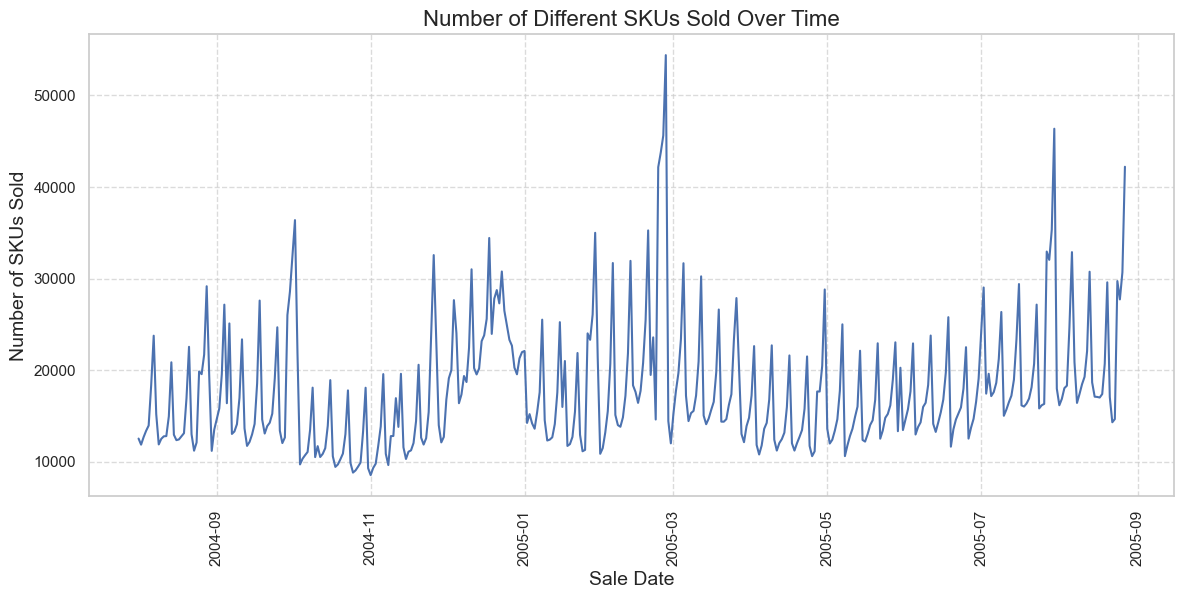

In [77]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(x="SALEDATE", y="SKU", data=tx_date, ax=ax)

ax.set_title("Number of Different SKUs Sold Over Time", fontsize=16)
ax.set_xlabel("Sale Date", fontsize=14)
ax.set_ylabel("Number of SKUs Sold", fontsize=14)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to Na

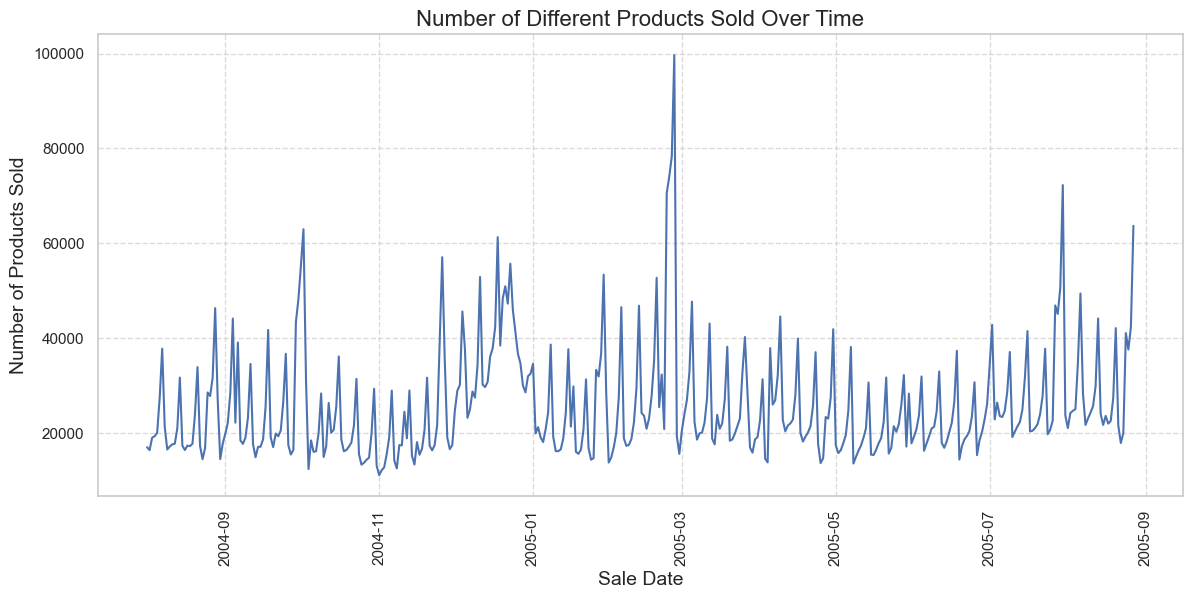

In [78]:
sns.set(style="whitegrid")
fig2, ax2 = plt.subplots(figsize=(14, 6))

sns.lineplot(x="SALEDATE", y="QUANTITY", data=tx_date, ax=ax2)

ax2.set_title("Number of Different Products Sold Over Time", fontsize=16)
ax2.set_xlabel("Sale Date", fontsize=14)
ax2.set_ylabel("Number of Products Sold", fontsize=14)
ax2.tick_params(axis='x', labelrotation=90)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.show()

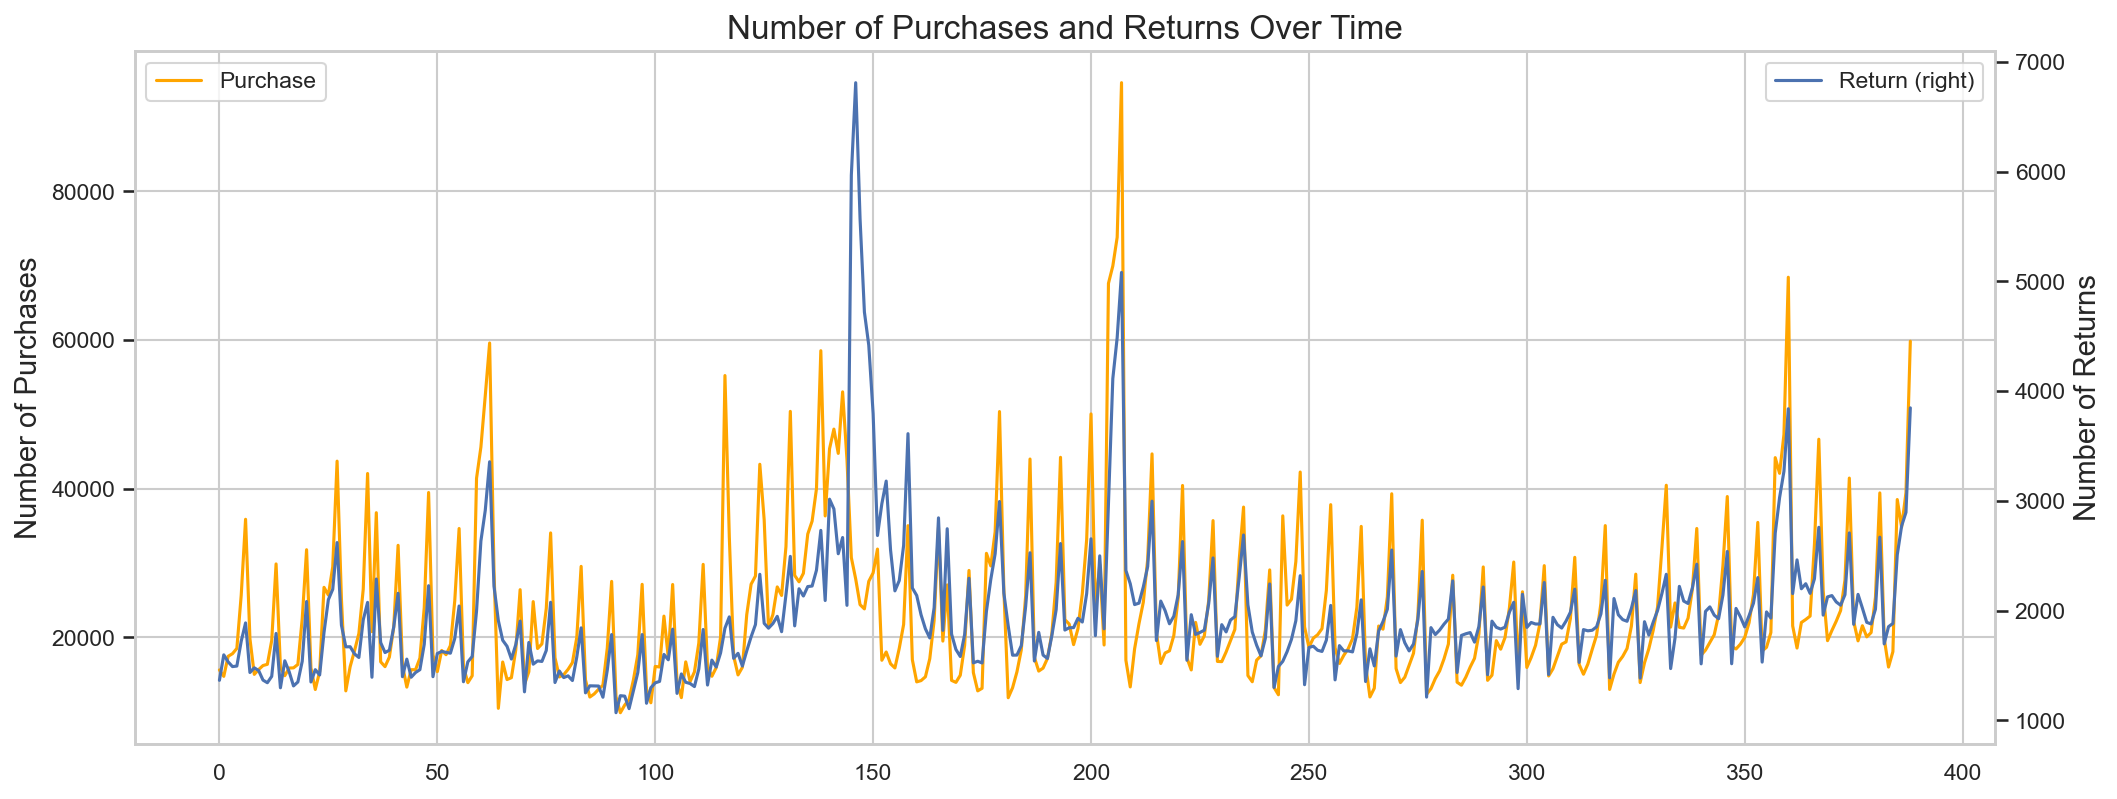

In [79]:
plt.figure(figsize=(16, 6), dpi=150)

ax = tx_date['PURCHASE'].plot.line(label='Purchase', color='orange')
ax2 = tx_date['RETURN'].plot.line(label='Return', secondary_y=True, ax=ax)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Number of Purchases and Returns Over Time', fontsize=16)
ax.set_ylabel('Number of Purchases', fontsize=14)
ax2.set_ylabel('Number of Returns', fontsize=14)

plt.show()

/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tianyuwu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to Na

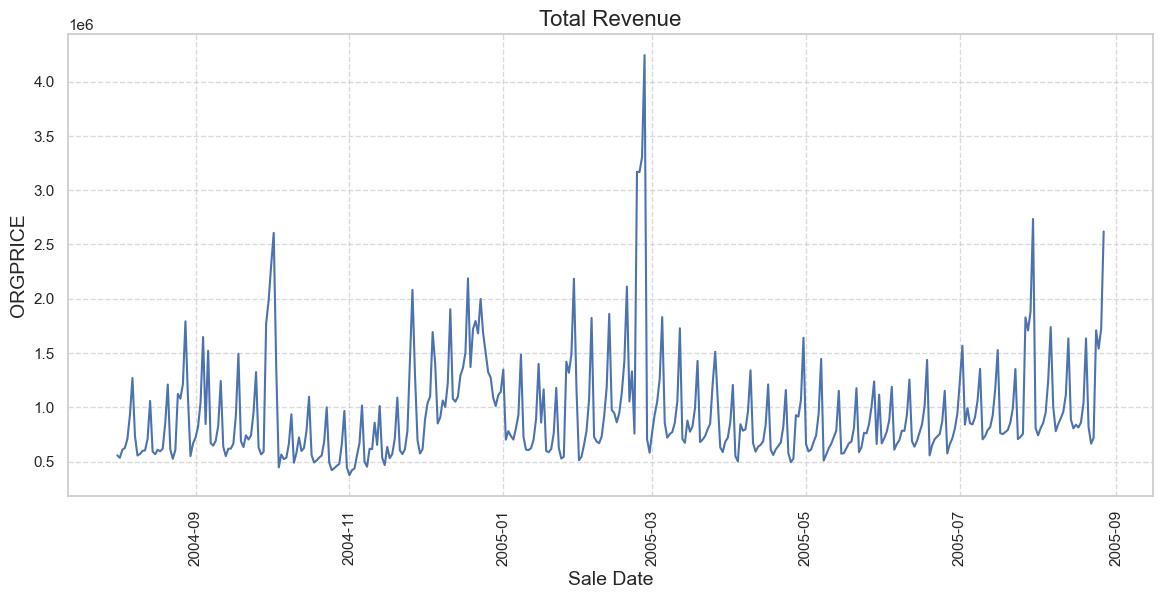

In [80]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(x="SALEDATE", y="ORGPRICE", data=tx_date, ax=ax)

ax.set_title("Total Revenue", fontsize=16)
ax.set_xlabel("Sale Date", fontsize=14)
ax.set_ylabel("ORGPRICE", fontsize=14)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [81]:
# Aggregate data by store 
tx_origprice = pd.pivot_table(tx,
                          values = "ORGPRICE",
                          index = 'SKU', 
                          aggfunc = 'mean').sort_values("ORGPRICE", ascending = False)
tx_origprice

,ORGPRICE
SKU,
7757187,1200.0
1161296,1200.0
6821285,1200.0
537667,1200.0
2701296,1200.0
...,...
3880077,0.0
8014680,0.0
8640765,0.0


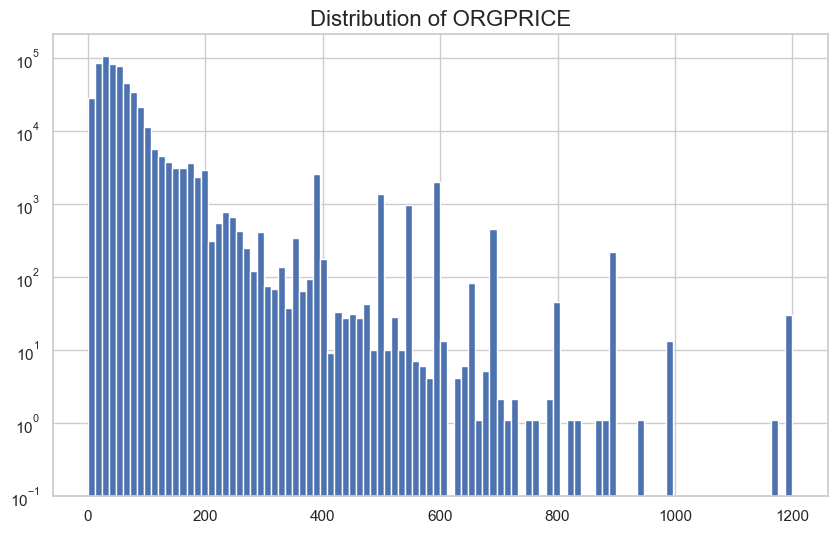

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))

tx_origprice.hist(ax=ax, bins=100, bottom=0.1)

plt.title("Distribution of ORGPRICE", fontsize=16)

# Set the y-scale to logarithmic for better visualization
ax.set_yscale('log')

# You can further customize the plot, add axis labels, or change the bin count as needed.

# Show the plot
plt.show()


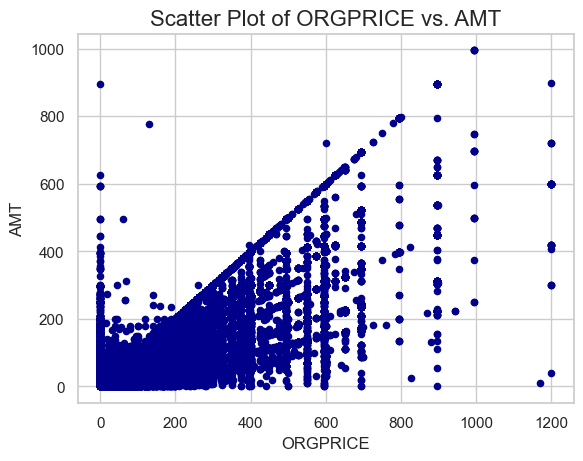

In [83]:
ax = tx.plot.scatter(x="ORGPRICE", y="AMT", c="DarkBlue")
plt.title("Scatter Plot of ORGPRICE vs. AMT", fontsize=16)
plt.show()

In [86]:
print(round(tx[tx["AMT"]>tx["ORGPRICE"]].shape[0]/tx.shape[0]*100, 2))
print(round(tx[tx["AMT"]==tx["ORGPRICE"]].shape[0]/tx.shape[0]*100, 2))
print(round(tx[tx["AMT"]<tx["ORGPRICE"]].shape[0]/tx.shape[0]*100, 2))

0.24
47.29
52.47
